## 5. Logistic Regression class implemented with NumPy - with AdaGrad 
The following code contains a logistic regression class that the functionality to optimise with gradient descent, AdaGrad and Newton's method.

Below that is a demonstration of the class, applied to a simple dataset, and the benefits of the different optimisation methods.

In [1]:
import numpy as np
from numpy.linalg import inv

In [2]:
class LogisticRegression():
    """logistic regression class with gradient descent, AdaGrad and Newtons method"""
    
    def __init__(self):
        
        self.weights = []
        self.loss = []
        self.data = []
        self.labels = []
        self.h = []
        
    def sigmoid(self, x):
        
        return 1 / (1 + np.exp(-x))
    
    def logloss(self, w, x, y, n):
        """loss fucntion"""
        
        rho = 1e-5
        h = self.sigmoid(x @ w)
        loss = -(1/n) * ((y.T @ np.log(h + rho)) + ((1 - y).T @ np.log(1 - h + rho)))
        return loss, h
    
    def adagrad(self, x, y, d, n, alpha, epochs):
        """adapts the step size based on scale of feature"""
        
        loss = np.zeros(epochs)
        
        eps = 1e-5
        
        #vector that stores sum of squared gradients for each dimention
        z = np.zeros((d, 1))
        
        w = np.zeros((d, 1))
        for i in range(epochs):
            
            #get gradient per dimention (no matrix multiplication - to keep dimentions separate)
            hd = self.sigmoid(x * w.T)
            dl = sum(x * (hd - y))[:, np.newaxis]
            
            #squared gradient per dimention
            z += dl**2
            
            #step size scaled according to individual dimention gradients
            w += - (1/n) * alpha * dl / np.sqrt(z + eps)
        
            loss[i], h = self.logloss(w, x, y, n)
        
        return w, h, loss
    
    def gradient_descent(self, x, y, d, n, alpha, epochs):
        """standard gradient descent method"""
        
        loss = np.zeros(epochs)
        w = np.zeros((d, 1))
        for i in range(epochs):
            h = self.sigmoid(x @ w)
            w += - (1/n) * alpha * (x.T @ (h - y))
            
            #keep track of logloss for plotting convergence
            loss[i], h = self.logloss(w, x, y, n)
        return w, h, loss
    
    def newton_descent(self, x, y, d, n, newtons):
        """Newton method for gradient descent, gives very quick concergence provided your relatively close
        to the minima, otherwise it could diverge"""
        
        w = self.weights
        for i in range(newtons):
            
            #calculate values for the diagonal matrix of the Hessian
            scalars = self.sigmoid(x @ w) * (1 - self.sigmoid(x @ w))
            D = np.diag(np.ravel(scalars))
            
            #calculate Hessian
            H = x.T @ D @ x
            
            #get predictions and calculate step
            h = self.sigmoid(x @ w)
            dl = x.T @ (h - y)
            w+= - inv(H) @ dl
            
            loss, h = self.logloss(w, x, y, n)
            #appends loss to array containing loss from GD/Adagrad steps
            self.loss = np.hstack((self.loss, np.ravel(loss)))
            
        self.weights = w
        self.h = h
        
        return
    
    def train(self, data, labels, alpha=0.01, epochs=1000, adagrad=False, newtons=0):
        """accepts num_data by num_features array of training data and 1d array of labels"""
        
        n = len(labels)
        x = np.hstack((data, np.ones((n, 1))))
        d = np.size(x, 1)
        y = labels[:, np.newaxis]
        
        #uses either adagrad or normal gradient descent to train model
        if adagrad == True:
            w, h, loss = self.adagrad(x, y, d, n, alpha, epochs)
        
        if adagrad == False:
            w, h, loss = self.gradient_descent(x, y, d, n, alpha, epochs)
        
        self.weights = w
        
        #storing for plotting purposes
        self.h = h
        self.loss = loss
        self.data = data
        self.labels = labels

        #option to do additional Newton steps for rapid convergence
        if newtons > 0:
            self.newton_descent(x, y, d, n, newtons)

    def predict(self, data):
        """Returns results and corresponding probabilities"""
        n = len(data)
        x = np.hstack((data, np.ones((n, 1))))
        
        probs = self.sigmoid(x @ self.weights)
        results = np.round(probs)
        return results, probs
    
    def get_missclassified(self):
        """retrieves the missclassified points from the training data"""
            
        x = np.round(np.ravel(self.h)) - self.labels
        return self.data[x != 0]
    
    def plot_boundary(self):
        """plots the training data and dividing boundary - for 2d data"""
        
        w = self.weights
        #getting training data
        x1 = self.data[self.labels == 0]
        x2 = self.data[self.labels == 1]
        
        #getting x and y values for dividing line
        x_vals = np.array([min(np.ravel(self.data)), max(np.ravel(self.data))])
        y = -1 * ((w[0]*x_vals + w[2]) / w[1])
        
        fig, ax = plt.subplots()
        
        #plotting training data
        ax.plot(x_vals, y, color='g')
        ax.scatter(x1[:, 0], x1[:, 1], label='0')
        ax.scatter(x2[:, 0], x2[:, 1], label='1')
        
        #getting and plotting miss-classified values
        reds = self.get_missclassified()
        if reds.size == 2:
            ax.scatter(reds[0], reds[1], color='r', label='miss-classified')
        if reds.size > 2:
            ax.scatter(reds[:, 0], reds[:, 1], color='r', label='miss-classified')
        
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_xlim(min(self.data[:,0]) - 1, max(self.data[:,0]) + 1)
        ax.set_ylim(min(self.data[:,1]) - 1, max(self.data[:,1]) + 1)
        plt.legend()
    
    def plot_loss(self):
        """plots graph of loss vs epochs"""
        
        fig, ax = plt.subplots()
        ax.plot(range(len(self.loss)), self.loss, color='r')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('loss')
    

In [3]:
from sklearn.datasets import make_classification

In [4]:
import matplotlib.pyplot as plt

### Generating suitable test data

In [5]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=1, n_redundant=0, n_clusters_per_class = 1,
                          random_state=14)

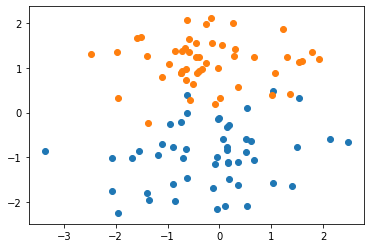

In [6]:
x1 = X[y == 0]
x2 = X[y == 1]
fig, ax = plt.subplots()
ax.scatter(x1[:, 0], x1[:, 1])
ax.scatter(x2[:, 0], x2[:, 1])

### Test 1 - only gradient descent - 1000 epochs

In [7]:
model = LogisticRegression()

model.train(X, y, epochs=1000)

results, probs = model.predict(X)

print(sum(results == y[:, np.newaxis])[0], '%')

96 %


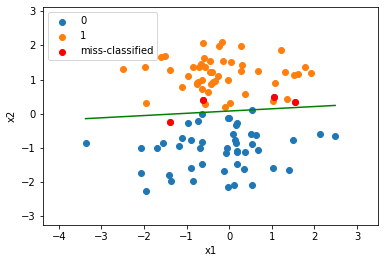

In [8]:
model.plot_boundary()

##### Converges as expected

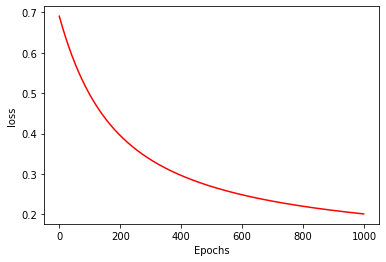

In [9]:
model.plot_loss()

In [10]:
model.loss[-1]

0.20097849738978021

### Test 2 - gradient descent and Newton's method - 200 GD steps then 3 Newton steps 

In [11]:
model = LogisticRegression()

model.train(X, y, epochs=200, newtons=3)

results, probs = model.predict(X)

print(sum(results == y[:, np.newaxis])[0], '%')

97 %


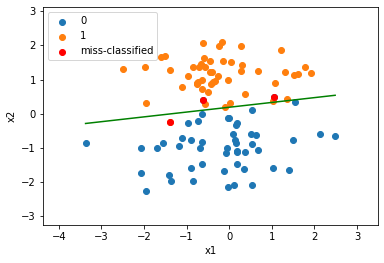

In [12]:
model.plot_boundary()

##### using newtons method drastically increases convergence time

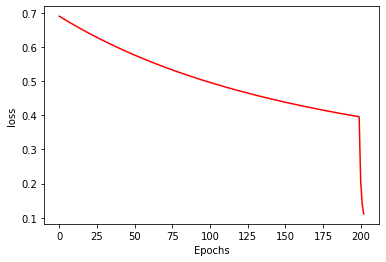

In [13]:
model.plot_loss()

In [14]:
model.loss[-1]

0.11102086635097262

### Test 3 - scaling x axis data by 100x to see the benefits of adagrad

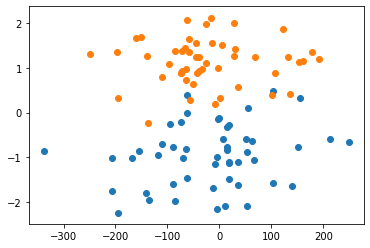

In [15]:
Xa = X * [100, 1]

xa1 = Xa[y == 0]
xa2 = Xa[y == 1]
fig, ax = plt.subplots()
ax.scatter(xa1[:, 0], xa1[:, 1])
ax.scatter(xa2[:, 0], xa2[:, 1])

In [16]:
model = LogisticRegression()

model.train(Xa, y, epochs=2000)

results, probs = model.predict(Xa)

print(sum(results == y[:, np.newaxis])[0], '%')

61 %


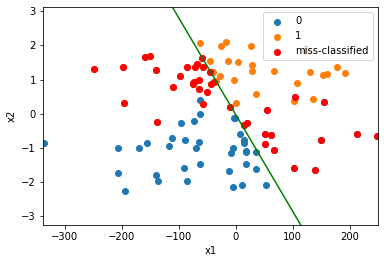

In [17]:
model.plot_boundary()

##### Using standard gradient descent it struggles to converge due to the different scales of the data features

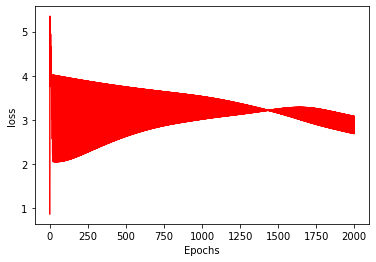

In [18]:
model.plot_loss()

In [19]:
model.loss[-1]

3.079756337070952

#### AdaGrad - setting alpha to 1 and letting the adagrad method take care of the scaling

In [20]:
model = LogisticRegression()

model.train(Xa, y, epochs=1500, adagrad=True, alpha=1)

results, probs = model.predict(Xa)

print(sum(results == y[:, np.newaxis])[0], '%')

94 %


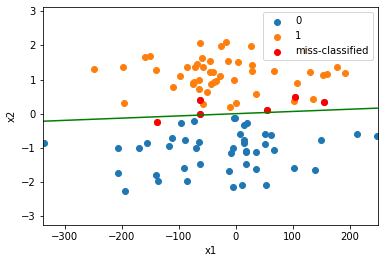

In [21]:
model.plot_boundary()

##### converges as expected, unaffected by the differently scaled data

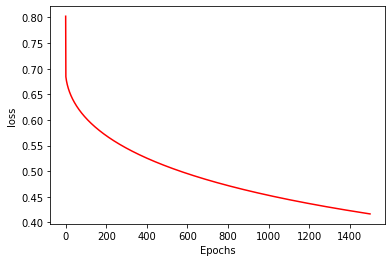

In [22]:
model.plot_loss()

In [23]:
model.loss[-1]

0.41662538949845784

##### Newtons method still works and converges very quickly

In [24]:
model = LogisticRegression()

model.train(Xa, y, epochs=100, adagrad=True, alpha=1, newtons=3)

results, probs = model.predict(Xa)

print(sum(results == y[:, np.newaxis])[0], '%')

97 %


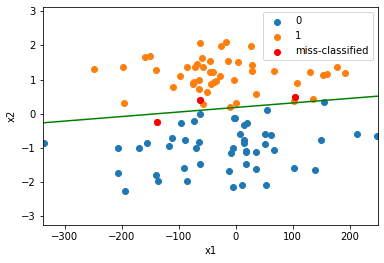

In [25]:
model.plot_boundary()

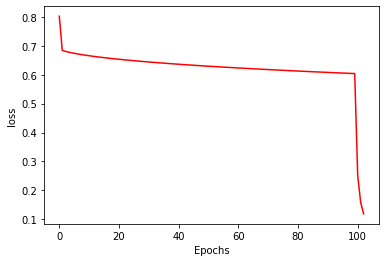

In [26]:
model.plot_loss()

In [27]:
model.loss[-1]

0.11847411512978853